# Precipitation Seasonal Climatology

* DJF and MAM for ERA5, IMERG-PM, and APHRODITE
* Total Seasonal Precip
* AR % contribution (seasonal)
* Standard Deviation

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as  pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
import cmocean.cm as cmo
import cmocean
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# Other
from scipy.ndimage import gaussian_filter
from pathlib import Path
from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
from ar_funcs import preprocess_ar_area_subregions, add_ar_time_series
import nclcmaps as nclc
from timeseries import calc_seasonal_contribution

### Set up paths

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


## Data

In [4]:
# start date and end date
start_date = '2000-12-01'
end_date = '2015-05-31'

# Select lat/lon grid
lonmin = 60
lonmax = 110
latmin = 15
latmax =  50

### AR time series

In [5]:
# read netCDF with fraction of area AR covers each subregion
filename = path_to_data + 'CH1_generated_data/ar_catalog_ERAI_fraction_HASIAsubregions.nc'
f1 = xr.open_dataset(filename)

# Set dates
f1 = f1.sel(time=slice(start_date, end_date))

## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=f1.to_dataframe(), thres=0.3)
# Show table
df.head()


,R01,R02,R03,ar,location
time,,,,,
2000-12-01,0.030612,0.0,0.020408,0,NaN
2000-12-02,0.081633,0.0,0.000000,0,NaN
2000-12-03,0.000000,0.0,0.000000,0,NaN
2000-12-04,0.030612,0.0,0.000000,0,NaN
2000-12-05,0.000000,0.0,0.000000,0,NaN


### APHRODITE

In [6]:
filename_pattern1 = path_to_data + 'APHRODITE/APHRO_MA_025deg_V1101.2*.nc'
f1 = xr.open_mfdataset(filename_pattern1, engine='netcdf4', concat_dim='time', combine='by_coords')
f1 = f1.rename({"longitude": "lon", "latitude": "lat"})
print('ds size in GB {:0.2f}\n'.format(f1.nbytes / 1e9))

filename_pattern2 = path_to_data + 'APHRODITE/APHRO_MA_025deg_V1101_*.nc'
f2 = xr.open_mfdataset(filename_pattern2, engine='netcdf4', concat_dim='time', combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(f2.nbytes / 1e9))

aphr = xr.merge([f1, f2])
aphr = aphr.sel(time=slice(start_date, end_date), lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
aphr

ds size in GB 2.36

ds size in GB 2.36



<xarray.Dataset>
Dimensions:  (lat: 140, lon: 200, time: 5295)
Coordinates:
  * time     (time) datetime64[ns] 2000-12-01 2000-12-02 ... 2015-05-31
  * lat      (lat) float64 15.12 15.38 15.62 15.88 ... 49.12 49.38 49.62 49.88
  * lon      (lon) float64 60.12 60.38 60.62 60.88 ... 109.1 109.4 109.6 109.9
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(2953, 140, 200), meta=np.ndarray>
    rstn     (time, lat, lon) float32 dask.array<chunksize=(2953, 140, 200), meta=np.ndarray>

### IMERG-PM

In [7]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

filename_pattern1 = path_to_data + 'IMERGV06B/3B-DAY.MS.MRG.3IMERG.20*.nc4'
gpm = xr.open_mfdataset(filename_pattern1, engine='netcdf4', concat_dim='time', combine='by_coords',
                           preprocess=preprocess)

print('ds size in GB {:0.2f}\n'.format(gpm.nbytes / 1e9))
gpm = gpm.transpose('lat', 'lon', 'time')
gpm = gpm.sel(time=slice(start_date, end_date))
gpm

ds size in GB 4.90



,Array,Chunk
Bytes,3.71 GB,700.00 kB
Shape,"(350, 500, 5295)","(350, 500, 1)"
Count,40295 Tasks,5295 Chunks
Type,float32,numpy.ndarray


### ERA5

In [8]:
### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

filepath_pattern = path_to_data + 'ERA5/prec/daily/out.era5*.nc'
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(f1.nbytes / 1e9))

# Create new dataset to rename lat lon
era = xr.Dataset({'prec': (['time', 'lat', 'lon'], f1['mtpr'].values*86400)},
                      coords={'time': (['time'], f1.time.values),
                              'lat': (['lat'], f1.latitude.values),
                              'lon': (['lon'], f1.longitude.values)})

era = era.sel(time=slice(start_date, end_date))
era

ds size in GB 1.66



<xarray.Dataset>
Dimensions:  (lat: 141, lon: 201, time: 5295)
Coordinates:
  * time     (time) datetime64[ns] 2000-12-01T09:00:00 ... 2015-05-31T09:00:00
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 15.75 15.5 15.25 15.0
  * lon      (lon) float32 60.0 60.25 60.5 60.75 ... 109.25 109.5 109.75 110.0
Data variables:
    prec     (time, lat, lon) float64 2.352 2.688 ... -8.047e-05 -8.047e-05

### Calculate climatologies

In [10]:
# put all precip ds into list
ds_list = [aphr, gpm, era]
prec_var = ['precip', 'precipitationCal', 'prec']

ds_clim_djf, ds_frac_djf, ds_std_djf = calc_seasonal_contribution(ds_list, df, prec_var, mon_s=12, mon_e=2)
ds_clim_mam, ds_frac_mam, ds_std_mam = calc_seasonal_contribution(ds_list, df, prec_var, mon_s=3, mon_e=5)

/home/sbarc/students/nash/anaconda3/envs/ar_types/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/sbarc/students/nash/anaconda3/envs/ar_types/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


## Create figure

In [11]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]

# cmap
cmap = cmo.rain
clipcmap = cmocean.tools.crop_by_percent(cmap, 20, which='min', N=None)
cmap = nclc.cmap('WhiteBlueGreenYellowRed')
cflevs = np.arange(0., 675., 50)

### Climatology Plots

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


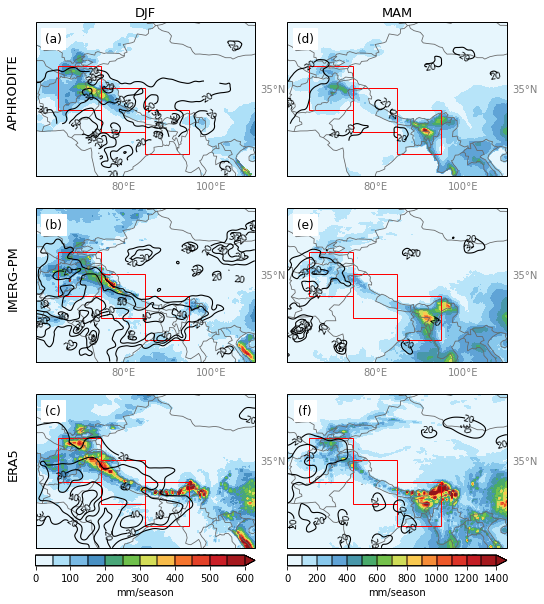

In [12]:
filepath = path_to_figs + 'prec_clim.png'
nrows = 3
ncols = 2

# Create figure
fig = plt.figure(figsize=(15,10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.10, cbar_size='7%',label_mode='',
                direction='column')

###############################
########## DJF PLOTS ##########
###############################
# set plot labels
col_labels = ['DJF', '', '']
row_labels = ['APHRODITE', 'IMERG-PM', 'ERA5']
alpha_lbl = ['(a)', '(b)', '(c)']
sig = [1.5, 5.0, 3.0]

for k, ax in enumerate(axgr[0:nrows]):
    cfdata = ds_clim_djf[k]
    cldata = ds_frac_djf[k]
    # lat/lon arrays
    lats = ds_list[k].lat.values
    lons = ds_list[k].lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled
    # Average Seasonal Total
    cflevs = np.arange(0., 650., 50)
    cf = ax.contourf(lons, lats, cfdata, transform=datacrs,
                    levels=cflevs,cmap=cmap, extend='max')
    
    # Contour Lines
    # Percent Contribution
    contr = gaussian_filter(cldata, sigma=sig[k])
    clevs = np.arange(20,105,10)
    cs = ax.contour(lons, lats, contr, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    kw_clabels = {'fontsize': 9, 'inline': True, 'inline_spacing': 8, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    # Subtitles
    # Column Labels
    ax.set_title(col_labels[k], loc='center', fontsize=13)
    # Row labels
    ax.text(-0.07, 0.55, row_labels[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
    # letters/subplots
    ax.text(0.08, 0.85, alpha_lbl[k], va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12., backgroundcolor='white')

    # Colorbar (single edge)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label('mm/season')
    cb.ax.tick_params(labelsize=10)
    
################################
########## MAM PLOTS ###########
################################
# set plot labels
col_labels = ['MAM', '', '']
alpha_lbl = ['(d)', '(e)', '(f)']
for k, ax in enumerate(axgr[nrows:nrows+nrows]):
    cfdata = ds_clim_mam[k]
    cldata = ds_frac_mam[k]
    # lat/lon arrays
    lats = ds_list[k].lat.values
    lons = ds_list[k].lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled
    # Average Seasonal Total
    cflevs = np.arange(0., 1450., 100)
    cf = ax.contourf(lons, lats, cfdata, transform=datacrs,
                    levels=cflevs,cmap=cmap, extend='max')
    
    # Contour Lines
    # Percent Contribution
    contr = gaussian_filter(cldata, sigma=sig[k])
    clevs = np.arange(20,105,10)
    cs = ax.contour(lons, lats, contr, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    kw_clabels = {'fontsize': 9, 'inline': True, 'inline_spacing': 8, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    # Subtitles
    # Column Labels
    ax.set_title(col_labels[k], loc='center', fontsize=13)
    # letters/subplots
    ax.text(0.08, 0.85, alpha_lbl[k], va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12., backgroundcolor='white')

    # Colorbar (single edge)
    cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label('mm/season')
    cb.ax.tick_params(labelsize=10)
    
# Save figure
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()


### Standard Deviation Plots

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


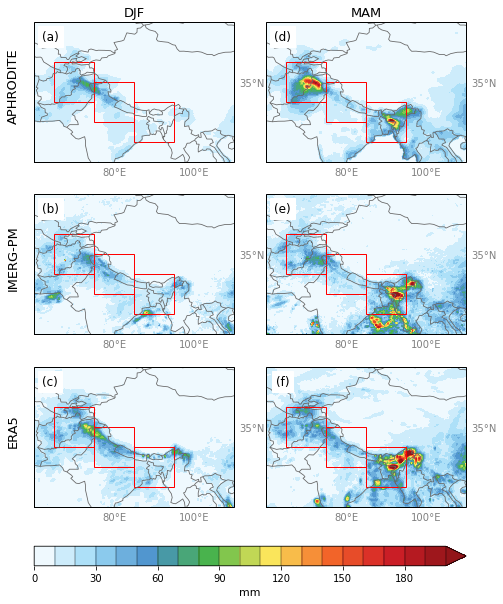

In [13]:
filepath = path_to_figs + 'prec_stddev.png'
nrows = 3
ncols = 2

# Create figure
fig = plt.figure(figsize=(15,10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.10, cbar_size='7%',label_mode='',
                direction='column')

###############################
########## DJF PLOTS ##########
###############################
# set plot labels
col_labels = ['DJF', '', '']
row_labels = ['APHRODITE', 'IMERG-PM', 'ERA5']
alpha_lbl = ['(a)', '(b)', '(c)']
for k, ax in enumerate(axgr[0:nrows]):
    cfdata = ds_std_djf[k]
    # lat/lon arrays
    lats = ds_list[k].lat.values
    lons = ds_list[k].lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled
    # Average Seasonal Total
    cflevs = np.arange(0., 210., 10)
    cf = ax.contourf(lons, lats, cfdata, transform=datacrs,
                    levels=cflevs,cmap=cmap, extend='max')
    
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    # Subtitles
    # Column Labels
    ax.set_title(col_labels[k], loc='center', fontsize=13)
    # Row labels
    ax.text(-0.07, 0.55, row_labels[k], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)
    # letters/subplots
    ax.text(0.08, 0.85, alpha_lbl[k], va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12., backgroundcolor='white')

################################
########## MAM PLOTS ###########
################################
# set plot labels
col_labels = ['MAM', '', '']
alpha_lbl = ['(d)', '(e)', '(f)']
for k, ax in enumerate(axgr[nrows:nrows+nrows]):
    cfdata = ds_std_mam[k]
    # lat/lon arrays
    lats = ds_list[k].lat.values
    lons = ds_list[k].lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled
    # Average Seasonal Total
    cf = ax.contourf(lons, lats, cfdata, transform=datacrs,
                    levels=cflevs,cmap=cmap, extend='max')
    
    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    # Subtitles
    # Column Labels
    ax.set_title(col_labels[k], loc='center', fontsize=13)
    # letters/subplots
    ax.text(0.08, 0.85, alpha_lbl[k], va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12., backgroundcolor='white')
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
cb.set_label('mm', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
